In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("fer2013/fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df.shape

(35887, 3)

## Plotting Shapes

<AxesSubplot:xlabel='emotion', ylabel='count'>

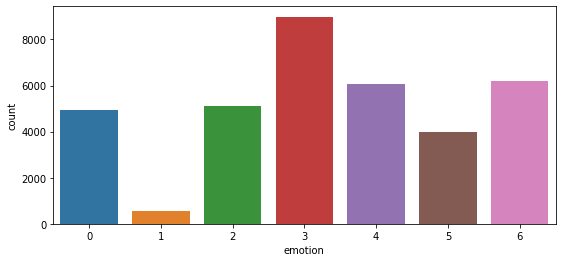

In [4]:
plt.figure(figsize = (9,4))
sns.countplot(x='emotion' , data = df)

In [5]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

Here we have
#### 0 : Angry
#### 1 : Disgust
#### 2 : Fear
#### 3 : Happy
#### 4 : Sad
#### 5 : Surprise
#### 6 : Neutral

<AxesSubplot:xlabel='Usage', ylabel='count'>

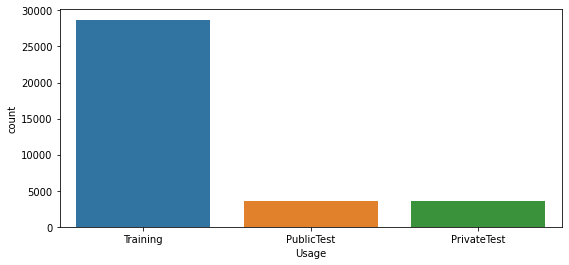

In [6]:
plt.figure(figsize=(9,4))
sns.countplot(x = 'Usage' , data=df)

## Preprocess

In [7]:
import cv2
image_size = (48,48)

In [8]:
#Convert column element to list for each row
pixels = df['pixels'].tolist()

w , h = 48 , 48
faces = []

for pixel_seq in pixels:
    face = [int(pixel) for pixel in pixel_seq.split(' ')]
    
    face = np.asarray(face).reshape(w,h)
    
    face = cv2.resize(face.astype('uint8') , image_size)
    
    faces.append(face.astype('float32'))
    
faces = np.asarray(faces)
faces = np.expand_dims(faces , -1)

emotions = pd.get_dummies(df['emotion']).to_numpy()

In [9]:
print(faces[2])
print(emotions[2])

[[[231.]
  [212.]
  [156.]
  ...
  [ 44.]
  [ 27.]
  [ 16.]]

 [[229.]
  [175.]
  [148.]
  ...
  [ 27.]
  [ 35.]
  [ 27.]]

 [[214.]
  [156.]
  [157.]
  ...
  [ 28.]
  [ 22.]
  [ 28.]]

 ...

 [[241.]
  [245.]
  [250.]
  ...
  [ 57.]
  [101.]
  [146.]]

 [[246.]
  [250.]
  [252.]
  ...
  [ 78.]
  [105.]
  [162.]]

 [[250.]
  [251.]
  [250.]
  ...
  [ 88.]
  [110.]
  [152.]]]
[0 0 1 0 0 0 0]


In [10]:
faces.shape

(35887, 48, 48, 1)

In [11]:
emotions.shape

(35887, 7)

## SPliiting Dataset

### Scalling data pixels b/w -1 to 1

In [12]:
x = faces.astype('float32')
x = x / 255.0

x = x - 0.5

x = x * 2.0

In [13]:
type(x)

numpy.ndarray

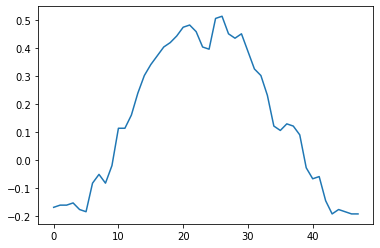

In [14]:
plt.plot(x[15,8])
plt.show()

In [15]:
x.min()

-1.0

In [16]:
x.max()

1.0

### Splitting Train and validate

In [17]:
num_samp , num_classes = emotions.shape

In [18]:
num_samp = len(x)
num_train_samp = int((1.0 - 0.2)*num_samp)

train_x , train_y = x[:num_train_samp] , emotions[:num_train_samp]

val_x , val_y = x[num_train_samp:] , emotions[num_train_samp:]

train_data = (train_x , train_y)
val_data = (val_x , val_y)

In [19]:
print("Training size" , train_x.shape)
print("Training labels size" , train_y.shape)
print("Validation pixels size" , val_x.shape)
print("Validation label size" , val_y.shape)

Training size (28709, 48, 48, 1)
Training labels size (28709, 7)
Validation pixels size (7178, 48, 48, 1)
Validation label size (7178, 7)


## Defining Model

In [20]:
from tensorflow.keras.layers import Activation , Convolution2D , Dropout , Conv2D
from tensorflow.keras.layers import AveragePooling2D , BatchNormalization , MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Flatten , Input , SeparableConv2D
from tensorflow.keras.regularizers import l2

In [21]:
input_shape = (48 , 48  ,1)
num_classes = 7

In [22]:
model = Sequential()

model.add(Convolution2D(filters = 16 , kernel_size = (7,7) , padding = 'same' , name = 'image_array' , input_shape = input_shape))
model.add(BatchNormalization())
model.add(Convolution2D(filters = 16 , kernel_size = (7,7) , padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size = (2,2) , padding = 'same'))
model.add(Dropout(0.5))

model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.5))

model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.5))

model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.5))

model.add(Convolution2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())

model.add(Convolution2D(filters=num_classes, kernel_size=(3, 3), padding='same'))
model.add(GlobalAveragePooling2D())

model.add(Activation('softmax',name='predictions'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_array (Conv2D)         (None, 48, 48, 16)        800       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 16)        12560     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 48, 48, 16)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 24, 24, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 16)        0

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(
                featurewise_center = False,
                featurewise_std_normalization = False,
                rotation_range = 10,
                width_shift_range = 0.1,
                height_shift_range = 0.1,
                zoom_range = 0.1,
                horizontal_flip = True
           )

In [25]:
from tensorflow.keras.callbacks import CSVLogger , ModelCheckpoint , EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [26]:
model.compile(optimizer='adam' , loss='categorical_crossentropy' , metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_array (Conv2D)         (None, 48, 48, 16)        800       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 16)        12560     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 48, 48, 16)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 24, 24, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 16)        0

In [27]:
batch_size = 32 
num_epochs = 200
verbose = 1 
num_classes = 7 
patience = 50

In [28]:
dataset = ['fer2013']
num_epochs = 30
base_path = '/'

for dataset_name in dataset:
    print('Training dataset : ' , dataset_name)
    
    log_file_path = dataset_name + '_emotion_training.log'
    
    csv_logger = CSVLogger(log_file_path , append=False)
    early_stop = EarlyStopping('val_loss' , patience= patience)
    reduce_lr = ReduceLROnPlateau('val_loss' , factor = 0.1 , patience=int(patience/4) , verbose=1)
    
    trained_models_path = base_path + dataset_name + 'simple_cnn'
    model_names = trained_models_path + '.{epoch:02d} - {val_loss:.2f}.hdf5'
    
    model_checkpoint = ModelCheckpoint(model_names , 'val_loss' , verbose=1 , save_best_only=True)
    
    my_callbacks = [model_checkpoint , csv_logger , early_stop , reduce_lr]
    
    train_faces , train_emotions = train_data
    history = model.fit_generator(data_gen.flow(train_faces , train_emotions , batch_size) , epochs = num_epochs , verbose=1 , callbacks=my_callbacks , validation_data=val_data)
    

Training dataset :  fer2013
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
898/898 [==============================] - ETA: 0s - loss: 1.7778 - accuracy: 0.2851
Epoch 00001: val_loss improved from inf to 1.69734, saving model to /fer2013simple_cnn.01 - 1.70.hdf5
898/898 [==============================] - 299s 333ms/step - loss: 1.7778 - accuracy: 0.2851 - val_loss: 1.6973 - val_accuracy: 0.3342
Epoch 2/30
898/898 [==============================] - ETA: 0s - loss: 1.6517 - accuracy: 0.3478
Epoch 00002: val_loss improved from 1.69734 to 1.51946, saving model to /fer2013simple_cnn.02 - 1.52.hdf5
898/898 [==============================] - 300s 334ms/step - loss: 1.6517 - accuracy: 0.3478 - val_loss: 1.5195 - val_accuracy: 0.4057
Epoch 3/30
898/898 [==============================] - ETA: 0s - loss: 1.5868 - accuracy: 0.3752
Epoch 00003: val_loss improved from 1.51946 to 1.47991, saving model to /fer2013simple_cnn.03 - 1.48.hdf5
898/898 [===============

898/898 [==============================] - ETA: 0s - loss: 1.2906 - accuracy: 0.5070
Epoch 00025: val_loss did not improve from 1.16843
898/898 [==============================] - 310s 345ms/step - loss: 1.2906 - accuracy: 0.5070 - val_loss: 1.1746 - val_accuracy: 0.5478
Epoch 26/30
898/898 [==============================] - ETA: 0s - loss: 1.2840 - accuracy: 0.5123
Epoch 00026: val_loss improved from 1.16843 to 1.14088, saving model to /fer2013simple_cnn.26 - 1.14.hdf5
898/898 [==============================] - 310s 345ms/step - loss: 1.2840 - accuracy: 0.5123 - val_loss: 1.1409 - val_accuracy: 0.5660
Epoch 27/30
898/898 [==============================] - ETA: 0s - loss: 1.2823 - accuracy: 0.5128
Epoch 00027: val_loss did not improve from 1.14088
898/898 [==============================] - 310s 345ms/step - loss: 1.2823 - accuracy: 0.5128 - val_loss: 1.1411 - val_accuracy: 0.5645
Epoch 28/30
898/898 [==============================] - ETA: 0s - loss: 1.2779 - accuracy: 0.5114
Epoch 00028

In [29]:
score = model.evaluate(val_x , val_y , verbose=1)
print('Test Loss : ' , score[0])
print('Test Accuracy : ' , score[1]*100 , "%")

225/225 [==============================] - 10s 43ms/step - loss: 1.1365 - accuracy: 0.5626
Test Loss :  1.1365233659744263
Test Accuracy :  56.255221366882324 %


In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [31]:
print(history_dict["accuracy"])

[0.2851022183895111, 0.3478003442287445, 0.3751785159111023, 0.3966003656387329, 0.41920652985572815, 0.43331360816955566, 0.44602736830711365, 0.45372530817985535, 0.4619109034538269, 0.4650806486606598, 0.4726392328739166, 0.4777944087982178, 0.4819394648075104, 0.48493504524230957, 0.4882092773914337, 0.49127450585365295, 0.4930509626865387, 0.49580270051956177, 0.49935561418533325, 0.49879828095436096, 0.4996342658996582, 0.4984847903251648, 0.5040231347084045, 0.5077153444290161, 0.5069838762283325, 0.5122783780097961, 0.5128008723258972, 0.5114075541496277, 0.5141593217849731, 0.5132536888122559]


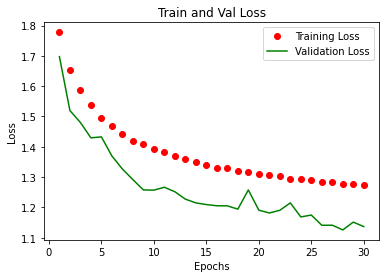

In [32]:
train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1,len(history_dict['accuracy']) + 1)

plt.plot(epochs , train_loss_values , 'ro' , label="Training Loss")
plt.plot(epochs , val_loss_values , 'g-' , label="Validation Loss")
plt.title('Train and Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

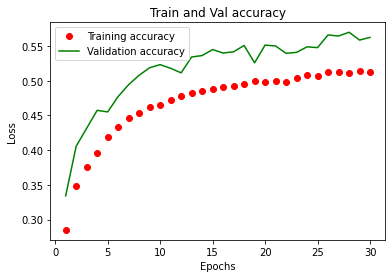

In [33]:
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, train_acc, 'ro', label='Training accuracy')
plt.plot(epochs, val_acc, 'g-', label='Validation accuracy')
plt.title('Train and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
model.save_weights("model.h5")

In [37]:
model.load_weights("model.h5")

In [38]:
from tensorflow.keras.models import model_from_json

In [39]:
model_json = model.to_json()
with open("model.json" , "w") as json_file:
    json_file.write(model_json)
    
print("Model saved to disk!!")

Model saved to disk!!


In [40]:
#Load json file
json_file = open("model.json" , "r")
loaded_model_json = json_file.read()

json_file.close()

model = model_from_json(loaded_model_json)

model.load_weights("model.h5")

### We can also load model using a function

In [41]:
def load_model():
    json_file = open("model.json" , "r")
    loaded_model_json = json_file.read()

    json_file.close()

    model = model_from_json(loaded_model_json)

    model.load_weights("model.h5")
    return model